## Libraries

In [1]:
import os
from collections import Counter
import pickle

import numpy as np

import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import Input, Model, layers, losses, optimizers, callbacks
from tensorflow.keras.datasets import mnist

from matplotlib import pyplot as plt

In [13]:
# load data
(xtrain_, ytrain), (xtest, ytest) = mnist.load_data()

# preprocessing: rescaling, reshaping
def preprocess_images(x):
    return x.astype('float32') / 255.

xtrain = preprocess_images(xtrain_)

# Split some data for training/validation/testing
Xtrain_, Xrest_, Ytrain, Yrest_ = train_test_split(xtrain, ytrain, train_size=10000)
Xval_, Xrest_, Yval, Yrest_ = train_test_split(Xrest_, Yrest_, train_size=1000)
Xtest_, Xrest_, Ytest, Yrest_ = train_test_split(Xrest_, Yrest_, train_size=10000)


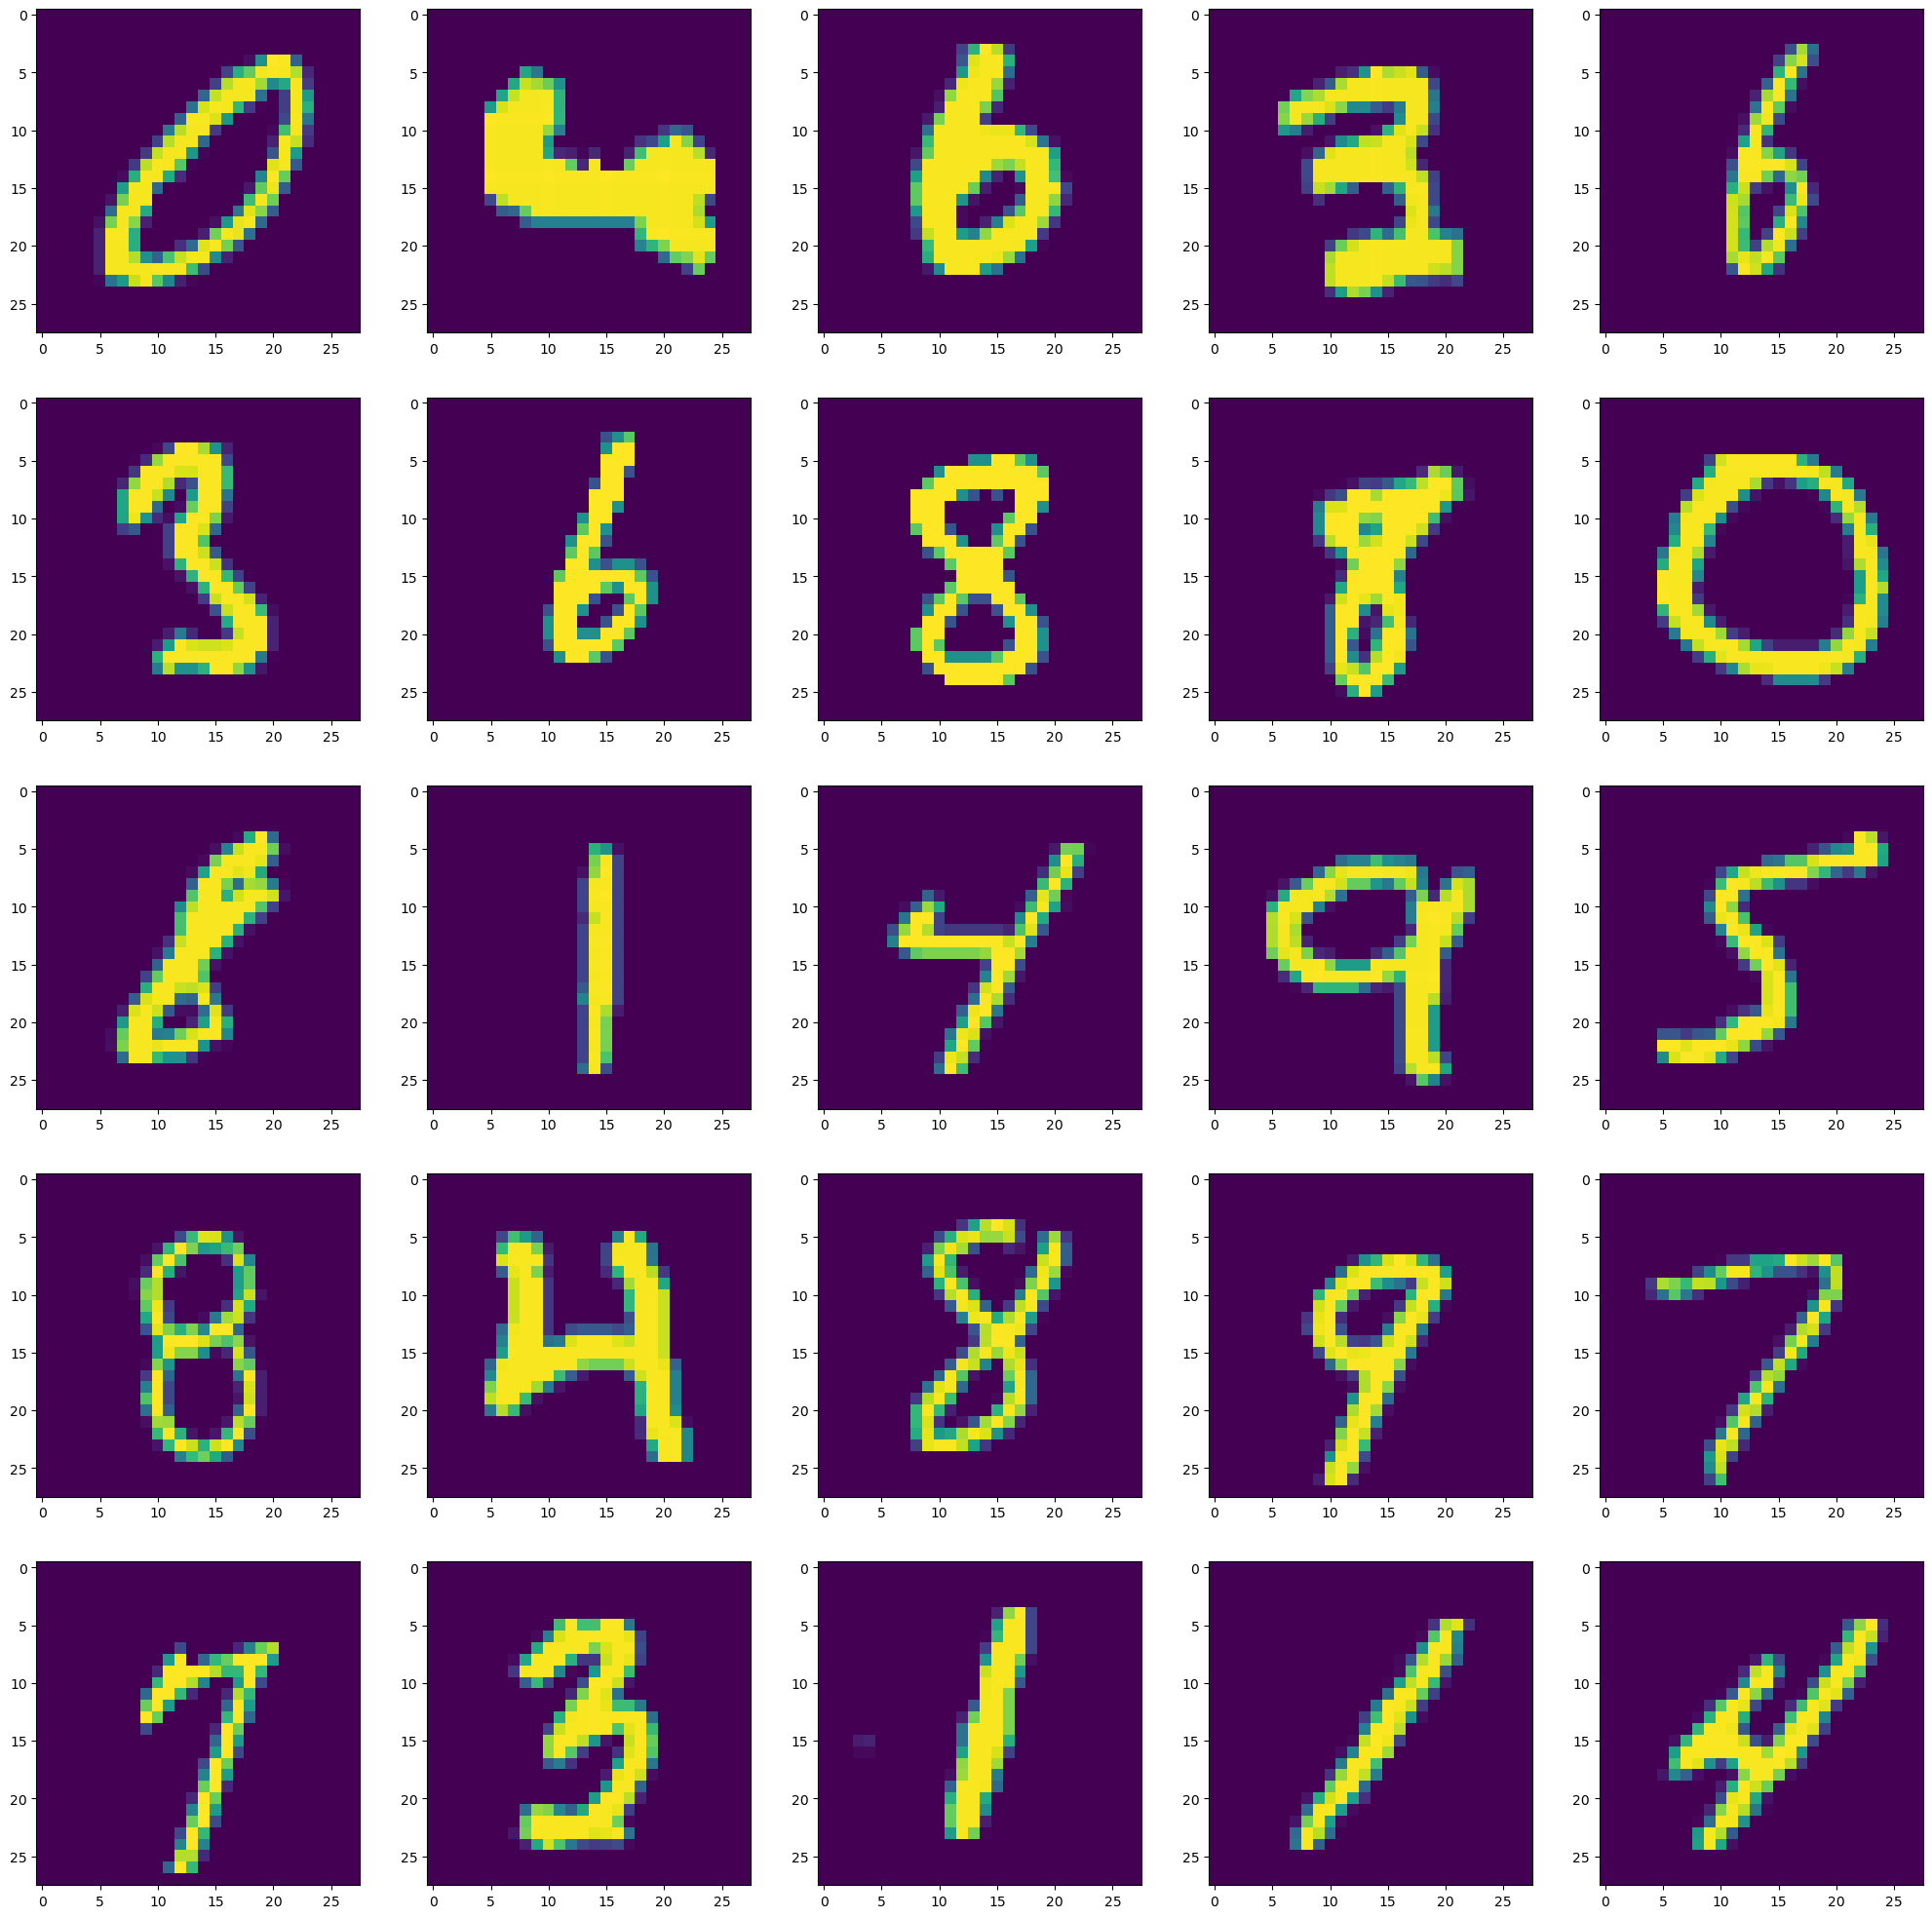

In [16]:
# plot some samples

idxs = np.random.choice(len(Xtrain_), 25, replace=False)
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
for idx, ax in zip(idxs, axs.flatten()):
    ax.imshow(Xtrain_[idx])

In [22]:
# sklearn needs the format n_samples x n_feature
Xtrain = Xtrain_.reshape((Xtrain_.shape[0], -1))
Xtest = Xtest_.reshape((Xtest_.shape[0], -1))
print(Xtrain.shape)
print(Counter(Ytrain))
                         

(10000, 784)
Counter({1: 1151, 0: 1036, 7: 1022, 3: 1008, 2: 1007, 9: 1000, 8: 999, 4: 970, 6: 956, 5: 851})


In [23]:
# train a classifier

LR = LogisticRegression(max_iter=1000)
LR.fit(Xtrain, Ytrain)

LogisticRegression(max_iter=1000)

In [24]:
# evaluate trained classifier on test set
Ypred = LR.predict(Xtest)
print(classification_report(Ytest, Ypred))
print(confusion_matrix(Ytest, Ypred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       970
           1       0.94      0.97      0.95      1046
           2       0.89      0.86      0.88       983
           3       0.89      0.88      0.88      1026
           4       0.91      0.91      0.91       974
           5       0.85      0.82      0.84       912
           6       0.91      0.95      0.93       957
           7       0.91      0.93      0.92      1082
           8       0.87      0.84      0.85      1014
           9       0.88      0.87      0.88      1036

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

[[ 937    0    3    1    1   12    8    0    8    0]
 [   1 1010    7    4    2    0    1    3   16    2]
 [   8   14  848   21   14    8   17   16   29    8]
 [   5    8   26  903    2   37    3   11   20   11]
 [   6    9    6    0  882   

In [25]:
# try a better model
RF = RandomForestClassifier()
RF.fit(Xtrain, Ytrain)

RandomForestClassifier()

In [26]:
# evaluate trained classifier on test set
Ypred2 = RF.predict(Xtest)
print(classification_report(Ytest, Ypred2))
print(confusion_matrix(Ytest, Ypred2))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       970
           1       0.97      0.98      0.98      1046
           2       0.94      0.95      0.94       983
           3       0.95      0.91      0.93      1026
           4       0.95      0.95      0.95       974
           5       0.93      0.93      0.93       912
           6       0.96      0.98      0.97       957
           7       0.95      0.96      0.96      1082
           8       0.95      0.92      0.93      1014
           9       0.92      0.93      0.92      1036

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

[[ 953    0    0    2    1    0    7    0    7    0]
 [   0 1026    4    5    1    1    0    4    5    0]
 [   4    3  929    5   11    1    6   12    8    4]
 [   2    4   18  936    2   26    3   11   10   14]
 [   3    2    5    0  924   

In [27]:
# Hyperparameter tuning
param_grid = {
    "n_estimators" : [200, 500],
    "max_depth" : [None, 10, 50],
    "max_features" : ["sqrt", "log2", .1]
}

RF_tuned = GridSearchCV(RandomForestClassifier(), 
                        param_grid=param_grid,
                        cv=4,
                        n_jobs=-1,
                        verbose=4)
RF_tuned.fit(Xtrain, Ytrain)

Fitting 4 folds for each of 18 candidates, totalling 72 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 50],
                         'max_features': ['sqrt', 'log2', 0.1],
                         'n_estimators': [200, 500]},
             verbose=4)

In [29]:
# display crossvalidation results
cv_results = pd.DataFrame(RF_tuned.cv_results_)
disp_cols = ["param_n_estimators", "param_max_depth", "param_max_features", "mean_fit_time", "mean_test_score"]
mapper = dict(zip(disp_cols[:3], ['n_estimators', 'max_depth', 'max_features']))
renamed_df = cv_results[disp_cols].copy()
renamed_df.rename(columns=mapper, inplace=True)
print(renamed_df.sort_values('mean_test_score', ascending=False))


   n_estimators max_depth max_features  mean_fit_time  mean_test_score
3           500      None         log2       6.177256           0.9484
13          500        50         sqrt      15.085491           0.9482
15          500        50         log2       6.330706           0.9481
1           500      None         sqrt      15.541328           0.9479
0           200      None         sqrt       6.116188           0.9468
12          200        50         sqrt       6.361325           0.9466
5           500      None          0.1      37.918133           0.9465
17          500        50          0.1      33.712355           0.9460
2           200      None         log2       2.496274           0.9456
16          200        50          0.1      15.070103           0.9454
14          200        50         log2       2.563825           0.9448
4           200      None          0.1      15.103297           0.9433
7           500        10         sqrt      12.721702           0.9370
11    

In [32]:
# evaluate trained classifier on test set
print(RF_tuned.best_params_)
Ypred3 = RF_tuned.predict(Xtest)
print(classification_report(Ytest, Ypred3))
print(confusion_matrix(Ytest, Ypred3))

{'max_depth': None, 'max_features': 'log2', 'n_estimators': 500}
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       970
           1       0.97      0.98      0.98      1046
           2       0.95      0.96      0.95       983
           3       0.94      0.92      0.93      1026
           4       0.95      0.94      0.95       974
           5       0.95      0.93      0.94       912
           6       0.96      0.98      0.97       957
           7       0.96      0.96      0.96      1082
           8       0.95      0.92      0.93      1014
           9       0.92      0.94      0.93      1036

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000

[[ 955    0    1    0    1    0    6    0    6    1]
 [   0 1028    6    3    1    1    0    2    4    1]
 [   6    2  940    4   10    1    2    9    9    0]
 [   2    5   17 

In [37]:
# Convolutional Neural Network in tensorflow using keras API

def mnist_clf(input_shape=(28, 28, 1), n_classes=10):
    inx = Input(input_shape)
    x = layers.Conv2D(32, kernel_size=(3, 3), strides=2, padding="same", activation="relu")(inx)
    x = layers.Conv2D(64, kernel_size=(3, 3), strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, kernel_size=(3, 3), strides=2, padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dense(n_classes)(x)
    return Model(inx, x)

clf_mnist = mnist_clf()
clf_mnist.summary()

# select loss function and optimizer
loss = losses.CategoricalCrossentropy(from_logits=True)
opt = optimizers.Nadam(learning_rate=1e-2)
clf_mnist.compile(loss=loss, optimizer=opt, metrics=["accuracy"])

# preprocess data: scaling of images, one-hot encoding of labels
def preprocess_tf(x, y):
    return x, tf.one_hot(y, depth=10, axis=-1)

trainset = tf.data.Dataset.from_tensor_slices((Xtrain_, Ytrain)).shuffle(Xtrain_.shape[0]).batch(256).map(preprocess_tf)
valset = tf.data.Dataset.from_tensor_slices((Xval_, Yval)).batch(1000).map(preprocess_tf)

# callback for saving model
MdlCpt = callbacks.ModelCheckpoint(".convert_mnist", save_best_only=True)
    

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dense_5 (Dense)             (None, 10)                1290

In [38]:
hist = clf_mnist.fit(trainset, 
                     validation_data=valset,
                     epochs=100,
                     callbacks=[MdlCpt])

Epoch 1/100


2022-10-30 16:10:52.450411: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-30 16:10:53.098748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - ETA: 0s - loss: 0.8107 - accuracy: 0.7391

2022-10-30 16:10:58.987744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: .convert_mnist/assets


INFO:tensorflow:Assets written to: .convert_mnist/assets


40/40 [==============================] - 7s 69ms/step - loss: 0.8107 - accuracy: 0.7391 - val_loss: 0.7642 - val_accuracy: 0.8210
Epoch 2/100
39/40 [============================>.] - ETA: 0s - loss: 0.1695 - accuracy: 0.9503

INFO:tensorflow:Assets written to: .convert_mnist/assets


INFO:tensorflow:Assets written to: .convert_mnist/assets


40/40 [==============================] - 2s 41ms/step - loss: 0.1692 - accuracy: 0.9504 - val_loss: 0.1230 - val_accuracy: 0.9550
Epoch 3/100
40/40 [==============================] - 1s 25ms/step - loss: 0.0674 - accuracy: 0.9775 - val_loss: 1.2360 - val_accuracy: 0.8060
Epoch 4/100
40/40 [==============================] - 1s 25ms/step - loss: 0.5278 - accuracy: 0.8770 - val_loss: 0.4678 - val_accuracy: 0.8590
Epoch 5/100
39/40 [============================>.] - ETA: 0s - loss: 0.0992 - accuracy: 0.9700

INFO:tensorflow:Assets written to: .convert_mnist/assets


INFO:tensorflow:Assets written to: .convert_mnist/assets


40/40 [==============================] - 2s 43ms/step - loss: 0.0991 - accuracy: 0.9700 - val_loss: 0.0988 - val_accuracy: 0.9680
Epoch 6/100
40/40 [==============================] - 1s 24ms/step - loss: 0.0314 - accuracy: 0.9904 - val_loss: 1.1002 - val_accuracy: 0.8430
Epoch 7/100
40/40 [==============================] - 1s 25ms/step - loss: 0.0773 - accuracy: 0.9791 - val_loss: 0.1067 - val_accuracy: 0.9740
Epoch 8/100
40/40 [==============================] - 1s 25ms/step - loss: 0.0147 - accuracy: 0.9958 - val_loss: 3.7326 - val_accuracy: 0.6880
Epoch 9/100
40/40 [==============================] - 1s 25ms/step - loss: 0.4906 - accuracy: 0.9003 - val_loss: 0.2545 - val_accuracy: 0.9480
Epoch 10/100
40/40 [==============================] - 1s 25ms/step - loss: 0.0505 - accuracy: 0.9820 - val_loss: 0.1447 - val_accuracy: 0.9640
Epoch 11/100
40/40 [==============================] - 1s 24ms/step - loss: 0.0131 - accuracy: 0.9957 - val_loss: 0.1614 - val_accuracy: 0.9590
Epoch 12/100
40/

Metrics on test set
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       970
           1       0.99      0.99      0.99      1046
           2       0.98      0.97      0.98       983
           3       0.98      0.97      0.98      1026
           4       0.98      0.97      0.97       974
           5       0.97      0.98      0.98       912
           6       0.99      0.99      0.99       957
           7       0.97      0.99      0.98      1082
           8       0.97      0.96      0.97      1014
           9       0.97      0.97      0.97      1036

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

[[ 964    0    0    0    0    2    2    0    2    0]
 [   1 1031    3    1    1    1    1    3    4    0]
 [   1    2  958    5    1    0    0    8    8    0]
 [   1    0    4  995    1    6    0    3    6   10]
 [   0   

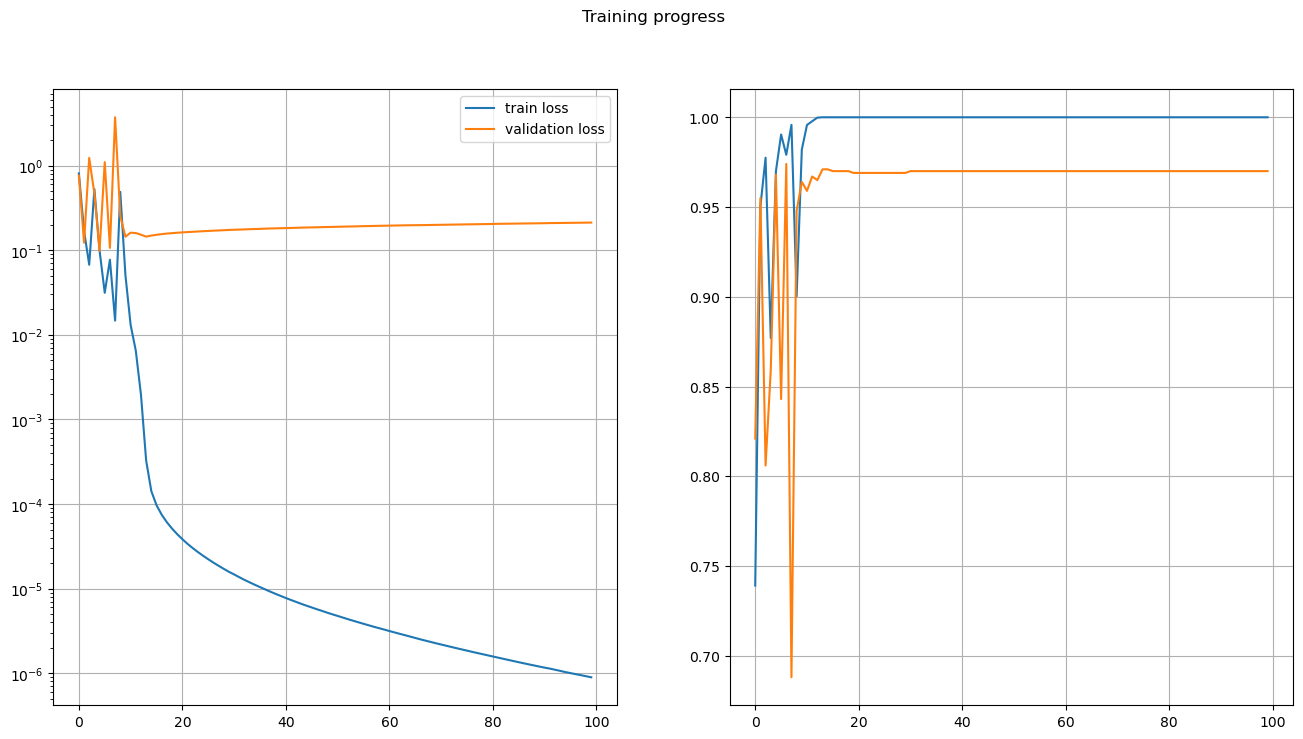

In [39]:
# plot training metrics

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].semilogy(hist.history["loss"], label="train loss")
ax[0].semilogy(hist.history["val_loss"], label="validation loss")
ax[1].plot(hist.history["accuracy"], label="train accuracy");
ax[1].plot(hist.history['val_accuracy'], label='validation accuracy');
ax[0].legend();
ax[1].legend;
ax[1].grid()
ax[0].grid()
fig.suptitle('Training progress')

print('Metrics on test set')
# display results with trained classifier (100 epochs)
Ypred4 = tf.argmax(clf_mnist(Xtest_), axis=-1)
print(classification_report(Ytest, Ypred4))
print(confusion_matrix(Ytest, Ypred4))

In [40]:
clf_mnist.evaluate(Xtest_, tf.one_hot(Ytest, depth=10), verbose=1)

313/313 [==============================] - 3s 8ms/step - loss: 0.2282 - accuracy: 0.9780


[0.22817941009998322, 0.9780000448226929]

In [43]:
# load best model from checkpoint
print('Best model found in epoch ', np.argmin(hist.history['val_loss'])+1)
clf2 = tf.keras.models.load_model('.convert_mnist')
Ypred5 = tf.argmax(clf2(Xtest_), axis=-1)
print(classification_report(Ytest, Ypred5))
print(confusion_matrix(Ytest, Ypred5))

Best model found in epoch  5
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       970
           1       0.99      0.98      0.98      1046
           2       0.96      0.97      0.97       983
           3       0.98      0.95      0.96      1026
           4       0.97      0.98      0.97       974
           5       0.96      0.97      0.97       912
           6       0.99      0.97      0.98       957
           7       0.96      0.98      0.97      1082
           8       0.96      0.94      0.95      1014
           9       0.95      0.97      0.96      1036

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

[[ 958    1    0    0    0    2    2    1    6    0]
 [   1 1021    4    0    4    2    1    3   10    0]
 [   1    2  953    7    2    1    0   13    4    0]
 [   1    1    8  977    1   10    0    9    5   14]
